<a href="https://colab.research.google.com/github/AzucenaMV/top2000-dashboard/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pycountry
!pip install geopy
!pip install folium

In [ ]:
import pandas as pd
import numpy as np
import os
import pycountry
import folium
import seaborn as sns

from geopy.geocoders import Nominatim
from folium.plugins import MarkerCluster

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_spotify = "spotify_features.csv"
path = 'drive/MyDrive/JADS/DataVizProject/Code/'
file_spotify = "spotify_features.csv"
file_gender = "top2000_gender.csv"

In [ ]:
df_gender = pd.read_csv(os.path.join(path,file_gender))
df_spotify = pd.read_csv(os.path.join(path,file_spotify))

In [ ]:
df = df_gender.merge(df_spotify, how = 'left', suffixes = ("","_sp"), on = 'index')

In [ ]:
df[df['song'].str.contains("\\(")][['song','song_name']]


,song,song_name
72,Another Brick in the Wall (part two),"Another Brick In the Wall, Part 2 - 2019 remix..."
96,Impossible (Orchestral Version),Impossible (Orchestral Version) [Live at Abbey...
114,(Sittin' on) The Dock of the Bay,(Sittin' On) The Dock of the Bay
172,Don't You (Forget About Me),Don't You (Forget About Me)
193,Gimme! Gimme! Gimme! (A Man After Midnight),Gimme! Gimme! Gimme! (A Man After Midnight)
...,...,...
4541,"Stay (Faraway, So Close!)","Stay (Faraway, So Close!)"
4544,(I can't help) falling in love with you,(I Can't Help) Falling In Love With You
4626,In the year 2525 (exordium and terminus),In the Year 2525 (Exordium & Terminus)
4630,Baila (sexy thing),Baila (Sexy Thing)


In [ ]:
# Fixing manually country
df.loc[df.artist == 'Prince & The Revolution','artist_country'] = 'US'
df.loc[df.artist == 'Danny Vera','artist_country'] = 'NL'
df.loc[df.artist == 'Floor Jansen & Henk Poort', 'artist_country'] = 'NL'

In [ ]:
n = 100
df_n =  df[:n] 
df_last_n = df[1949:2000]

# Location

In [ ]:
def get_country_name(value): 
  if not pd.isna(value):
    country = pycountry.countries.get(alpha_2=value).name
  else:
    country = ''
  return country

In [ ]:
df['artist_country_name'] = df.artist_country.apply(lambda x: get_country_name(x))

In [ ]:
df.artist_country_name.value_counts().head(10)

United States     1759
United Kingdom    1459
Netherlands        552
                   126
Canada             107
Ireland             82
France              76
Germany             69
Australia           63
Sweden              62
Name: artist_country_name, dtype: int64

In [ ]:
df_n_country = df_n.groupby(['artist_country']).size().reset_index(name = 'num_artist')

In [ ]:
geolocator = Nominatim(user_agent="http")
def geolocate(country):
    try:
        # Geolocate the center of the country
        loc = geolocator.geocode(country)
        # And return latitude and longitude
        return (loc.latitude, loc.longitude)
    except:
        # Return missing value
        return (np.nan, np.nan)

In [ ]:
geo = df_n_country.artist_country.apply(lambda x: geolocate(x))


In [ ]:
df_geo = pd.DataFrame(geo.tolist(), columns=['lat', 'long'], index=geo.index) \
         .apply(pd.to_numeric, errors='coerce')
df_n_country_geo = pd.concat([df_n_country, df_geo], axis=1)
df_n_geo = df_n.merge(df_n_country_geo, how = 'inner', on = 'artist_country')

In [ ]:
#empty map
world_map= folium.Map(tiles="cartodbpositron",control_scale=True)
marker_cluster = MarkerCluster().add_to(world_map)#for each coordinate, create circlemarker of user percent
for i in range(len(df_n_geo)):
        lat = df_n_geo.iloc[i]['lat']
        long = df_n_geo.iloc[i]['long']
        radius= 15
        popup_text = """Country : {}<br>
                        artist : {}<br>
                        song : {}"""
        popup_text = popup_text.format(df_n_geo.iloc[i]['artist_country_name'],
                                   df_n_geo.iloc[i]['artist'],
                                   df_n_geo.iloc[i]['song_name']

                                   )
        folium.CircleMarker(location = [lat, long], radius=radius, popup= popup_text, fill =True).add_to(marker_cluster)#show the map

world_map

In [ ]:
# TODO: BY ARTIST
#df_n.drop_duplicates(subset = ['artist','artist_country'])['artist','artist_country']

# Audio Features 

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import matplotlib. pyplot as plt

- Danceability: Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.
- Acousticness: A measure from 0.0 to 1.0 of whether the track is acoustic.
- Energy: Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. 
- Instrumentalness: Predicts whether a track contains no vocals. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. \\
- Liveness: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live.
- Loudness: The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track. Values typical range between -60 and 0 db.
- Speechiness: Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value.
- Tempo: The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.
- Valence: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

https://medium.com/@boplantinga/what-do-spotifys-audio-features-tell-us-about-this-year-s-eurovision-song-contest-66ad188e112a

In [ ]:
audio_features = df_n.columns[df_n.columns.get_loc('danceability'):(df_n.columns.get_loc('tempo')+1)]
df_n[audio_features].describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.474720,0.548962,4.810000,-9.463780,0.670000,0.048998,0.338583,0.065423,0.230256,0.377471,118.940530
std,0.122869,0.227537,3.430979,3.419132,0.472582,0.045566,0.310518,0.172763,0.238516,0.215288,28.775813
min,0.149000,0.094500,0.000000,-20.084000,0.000000,0.024300,0.000025,0.000000,0.032700,0.039200,56.874000
25%,0.386750,0.365750,2.000000,-11.732000,0.000000,0.029875,0.043175,0.000005,0.093125,0.199250,96.901250
50%,0.480000,0.535000,5.000000,-9.196000,1.000000,0.034000,0.247500,0.000458,0.120500,0.350500,116.125000
75%,0.559750,0.729750,7.000000,-6.880000,1.000000,0.045300,0.596750,0.008153,0.252750,0.489750,138.250250
max,0.733000,0.947000,11.000000,-4.046000,1.000000,0.304000,0.970000,0.838000,0.981000,0.931000,189.507000


### Top n distributions

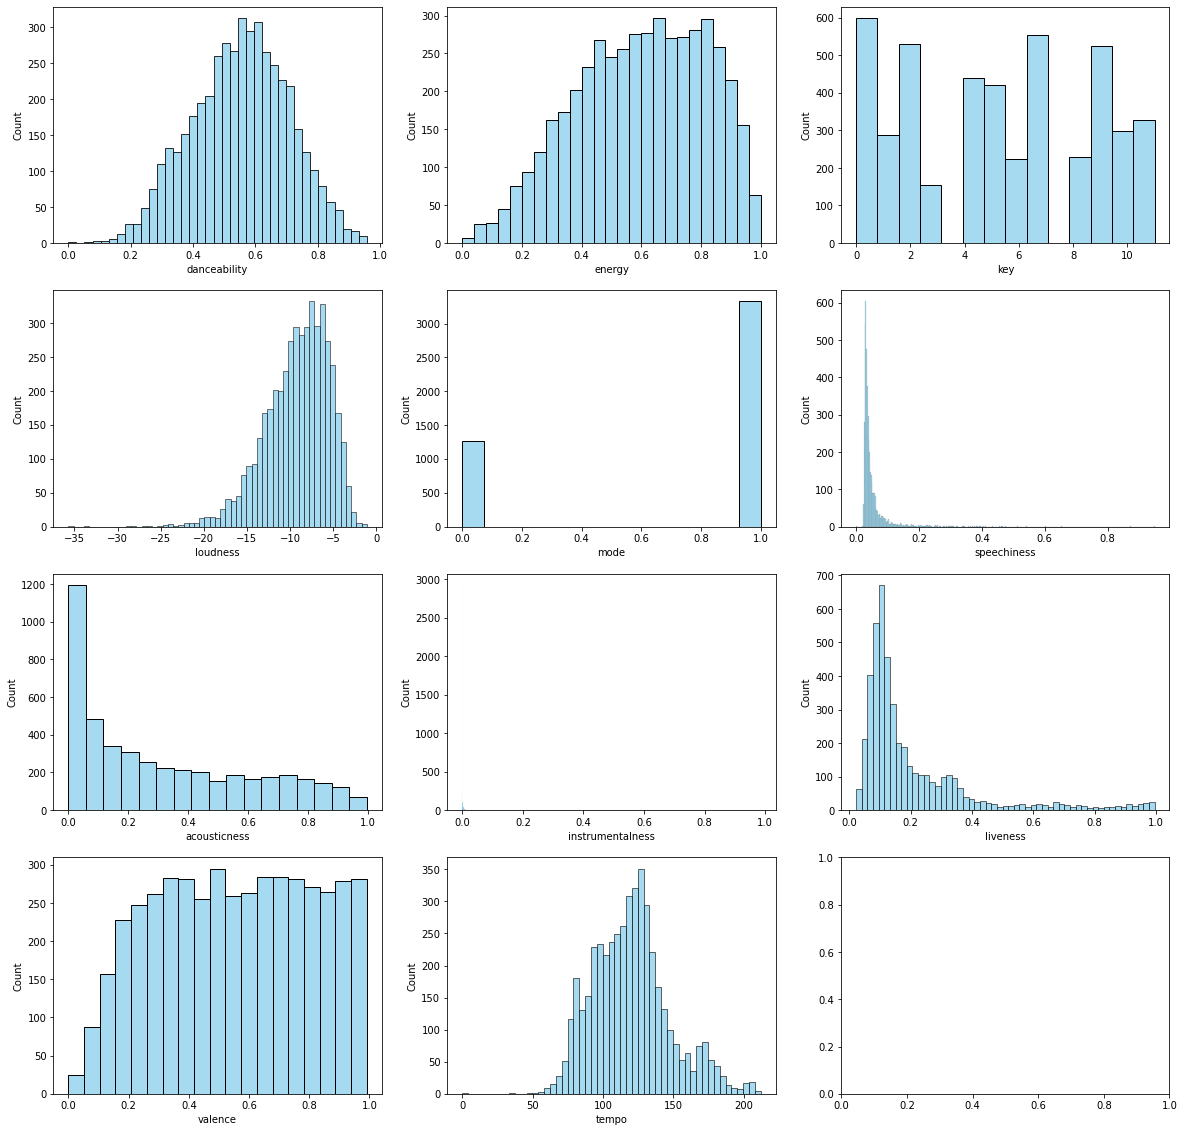

In [ ]:
f, axes = plt.subplots(4, 3, figsize=(20, 20), sharex=False)
for ax, feature in zip(axes.flat, audio_features):
    sns.histplot(df[feature] , color="skyblue", ax=ax)


    Dub: 60-90 bpm
    Hip-hop: 60-100 bpm
    House: 115-130 bpm
    Techno/trance: 120-140 bpm
    Dubstep: 135-145 bpm
    Drum and bass: 160-180 bpm


### Clustering

In [ ]:
X = df_n[audio_features].values
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

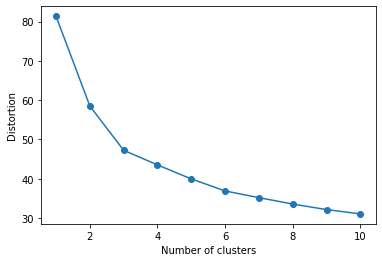

In [ ]:
distortions = []
for i in range(1, 11):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(X_scaled)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [ ]:
km = KMeans(
    n_clusters=3, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)
y_km = km.fit_predict(X_scaled)
centroids  = km.cluster_centers_

In [ ]:
df_n = df_n.assign(clusters = y_km.reshape(-1,1))

In [ ]:
df_n[df_n['clusters'] == 0].sample(5)

,artist,song,released_date,highest_position,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,artist_clean,chartmetric_id,artist_right,artist_country,pronoun,gender,is_band,genre,index,song_id,song_name,artist_name,artist_id,album_name,album_date,song_popularity,duration_ms,search_includes_artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms_feature,time_signature,artist_genre,artist_popularity,artist_name_artist,artist_country_name,clusters
90,The Rolling Stones,Angie,1973,8,8,9,22,12,10,13,18,21,45,20,36,35,41,26,46,54,77,78,70,79,90,79,91,the rolling stones,216.0,The Rolling Stones,GB,they/them,male,True,"{rock,""classic rock"",Rock,""album rock"",""album ...",90,1GcVa4jFySlun4jLSuMhiq,Angie,The Rolling Stones,22bE4uQ6baNwSHPVcDxLCe,Goats Head Soup (Remastered 2009),1973-08-31,75.0,272000.0,1.0,0.429,0.554,9.0,-6.128,0.0,0.0291,0.670,0.000152,0.1050,0.4070,136.302,audio_features,1GcVa4jFySlun4jLSuMhiq,spotify:track:1GcVa4jFySlun4jLSuMhiq,https://api.spotify.com/v1/tracks/1GcVa4jFySlu...,https://api.spotify.com/v1/audio-analysis/1GcV...,272000.0,4.0,"['british invasion', 'classic rock', 'rock']",81.0,The Rolling Stones,United Kingdom,0
87,AC/DC,Highway to Hell,1979,43,—,—,—,—,—,—,—,—,—,—,—,—,128,114,121,66,91,65,43,59,66,78,88,ac/dc,314.0,AC/DC,AU,they/them,male,True,"{Rock,""Hard Rock"",Metal,""hard rock"",rock,""aust...",87,2zYzyRzz6pRmhPzyfMEC8s,Highway to Hell,AC/DC,711MCceyCBcFnzjGY4Q7Un,Highway to Hell,1979-07-27,86.0,208400.0,1.0,0.574,0.913,6.0,-4.793,0.0,0.1330,0.061,0.001580,0.1560,0.4230,115.728,audio_features,2zYzyRzz6pRmhPzyfMEC8s,spotify:track:2zYzyRzz6pRmhPzyfMEC8s,https://api.spotify.com/v1/tracks/2zYzyRzz6pRm...,https://api.spotify.com/v1/audio-analysis/2zYz...,208400.0,4.0,"['australian rock', 'hard rock', 'rock']",84.0,AC/DC,Australia,0
18,Disturbed,The Sound of Silence,2016,18,×,×,×,×,×,×,×,×,×,×,×,×,×,×,×,×,×,518,54,39,18,20,19,disturbed,90.0,Disturbed,US,they/them,male,True,"{""Hard Rock"",Rock,Metal,""rap metal"",""alternati...",18,1Cj2vqUwlJVG27gJrun92y,The Sound of Silence,Disturbed,3TOqt5oJwL9BE2NG9MEwDa,Immortalized,2015-08-21,75.0,248466.0,1.0,0.322,0.280,6.0,-9.367,0.0,0.0281,0.468,0.000001,0.1020,0.1750,85.794,audio_features,1Cj2vqUwlJVG27gJrun92y,spotify:track:1Cj2vqUwlJVG27gJrun92y,https://api.spotify.com/v1/tracks/1Cj2vqUwlJVG...,https://api.spotify.com/v1/audio-analysis/1Cj2...,248467.0,4.0,"['alternative metal', 'nu metal', 'rap metal']",77.0,Disturbed,United States,0
0,Queen,Bohemian Rhapsody,1975,1,1,1,1,1,1,1,2,1,1,1,1,2,1,1,1,2,2,1,1,1,1,2,1,queen,72.0,Queen,GB,they/them,male,True,"{""classic rock"",""glam rock"",rock,rock,""pop roc...",0,4u7EnebtmKWzUH433cf5Qv,Bohemian Rhapsody - Remastered 2011,Queen,1dfeR4HaWDbWqFHLkxsg1d,A Night At The Opera (2011 Remaster),1975-11-21,84.0,354320.0,1.0,0.414,0.404,0.0,-9.928,0.0,0.0499,0.271,0.000000,0.3000,0.2240,71.105,audio_features,4u7EnebtmKWzUH433cf5Qv,spotify:track:4u7EnebtmKWzUH433cf5Qv,https://api.spotify.com/v1/tracks/4u7EnebtmKWz...,https://api.spotify.com/v1/audio-analysis/4u7E...,354320.0,4.0,"['classic rock', 'glam rock', 'rock']",88.0,Queen,United Kingdom,0
46,Supertramp,School,1974,14,26,17,16,14,21,34,37,36,52,33,46,44,37,35,37,41,52,48,44,44,41,45,47,supertramp,206665.0,Supertramp,GB,they/them,male,True,"{Pop/Rock,Rock,Pop,""soft rock"",""classic rock"",...",46,6fnachl7fIn5dqIjakfJ57,School,Supertramp,3JsMj0DEzyWc0VDlHuy9Bx,Crime Of The Century (Remastered),1974-09-01,65.0,335286.0,1.0,0.366,0.468,4.0,-14.514,0.0,0.0826,0.537,0.028300,0.0664,0.0506,90.281,audio_features,6fnachl7fIn5dqIjakfJ57,spotify:track:6fnachl7fIn5dqIjakfJ57,https://api.spotify.com/v1/tracks/6fnachl7fIn5...,https://api.spotify.com/v1/audio-analysis/6fna...,335286.0,4.0,"['album rock', 'art rock', 'classic rock', 'gl...",72.0,Supertramp,United Kingdom,0


In [ ]:
df_n[df_n['clusters'] == 1].sample(5)

,artist,song,released_date,highest_position,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,artist_clean,chartmetric_id,artist_right,artist_country,pronoun,gender,is_band,genre,index,song_id,song_name,artist_name,artist_id,album_name,album_date,song_popularity,duration_ms,search_includes_artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms_feature,time_signature,artist_genre,artist_popularity,artist_name_artist,artist_country_name,clusters
3,Eagles,Hotel California,1977,1,2,4,3,3,2,2,3,3,3,2,2,1,2,2,2,1,3,2,2,2,2,3,4,eagles,751.0,Eagles,US,they/them,male,True,"{""classic rock"",""yacht rock"",""country rock"",""h...",3,40riOy7x9W7GXjyGp4pjAv,Hotel California - 2013 Remaster,Eagles,0ECwFtbIWEVNwjlrfc6xoL,Hotel California (2013 Remaster),1976-12-08,86.0,391376.0,1.0,0.579,0.508,2.0,-9.484,1.0,0.0270,0.005740,0.000494,0.0575,0.609,147.125,audio_features,40riOy7x9W7GXjyGp4pjAv,spotify:track:40riOy7x9W7GXjyGp4pjAv,https://api.spotify.com/v1/tracks/40riOy7x9W7G...,https://api.spotify.com/v1/audio-analysis/40ri...,391376.0,4.0,"['album rock', 'classic rock', 'country rock',...",78.0,Eagles,United States,1
66,U2,With or Without You,1987,26,51,26,52,35,40,38,47,48,48,46,62,62,86,53,47,45,56,59,41,52,55,53,67,u2,75.0,U2,IE,they/them,male,True,"{""irish rock"",rock,""permanent wave"",rock,elect...",66,6ADSaE87h8Y3lccZlBJdXH,With Or Without You - Remastered,U2,51Blml2LZPmy7TTiAg47vQ,The Joshua Tree (Super Deluxe),1987-03-03,82.0,295515.0,1.0,0.540,0.429,2.0,-11.822,1.0,0.0285,0.000202,0.355000,0.1410,0.113,110.171,audio_features,6ADSaE87h8Y3lccZlBJdXH,spotify:track:6ADSaE87h8Y3lccZlBJdXH,https://api.spotify.com/v1/tracks/6ADSaE87h8Y3...,https://api.spotify.com/v1/audio-analysis/6ADS...,295516.0,4.0,"['irish rock', 'permanent wave', 'rock']",81.0,U2,Ireland,1
76,Fleetwood Mac,The Chain,1977,77,—,—,—,—,—,—,—,—,—,—,—,—,—,—,1835,551,465,520,252,157,149,109,77,fleetwood mac,100.0,Fleetwood Mac,GB,they/them,mixed,True,"{Rock,""album rock"",""mellow gold"",""classic rock...",76,5e9TFTbltYBg2xThimr0rU,The Chain - 2004 Remaster,Fleetwood Mac,08GQAI4eElDnROBrJRGE0X,Rumours (Super Deluxe),1977-02-04,83.0,270213.0,1.0,0.545,0.670,9.0,-8.810,1.0,0.0496,0.009000,0.000822,0.0451,0.481,151.553,audio_features,5e9TFTbltYBg2xThimr0rU,spotify:track:5e9TFTbltYBg2xThimr0rU,https://api.spotify.com/v1/tracks/5e9TFTbltYBg...,https://api.spotify.com/v1/audio-analysis/5e9T...,270213.0,4.0,"['album rock', 'classic rock', 'mellow gold', ...",83.0,Fleetwood Mac,United Kingdom,1
10,Coldplay,Fix You,2005,8,×,×,×,×,×,×,—,—,—,—,1494,235,69,40,20,15,10,11,8,9,8,8,11,coldplay,439.0,Coldplay,GB,they/them,male,True,"{Rock,Pop,Alternative,pop,""permanent wave""}",10,4XgBVDnjx13IDV33nTj9Rk,Fix You,Coldplay,4gzpq5DPGxSnKTe4SA8HAU,Pop Tearjerkers,2022-02-25,1.0,277400.0,1.0,0.206,0.470,3.0,-7.205,1.0,0.0333,0.125000,0.000454,0.0907,0.136,139.109,audio_features,4XgBVDnjx13IDV33nTj9Rk,spotify:track:4XgBVDnjx13IDV33nTj9Rk,https://api.spotify.com/v1/tracks/4XgBVDnjx13I...,https://api.spotify.com/v1/audio-analysis/4XgB...,277400.0,4.0,"['permanent wave', 'pop']",91.0,Coldplay,United Kingdom,1
32,Guns N' Roses,Sweet Child o' Mine,1987,32,—,—,—,—,—,—,—,—,144,890,89,103,67,57,58,65,55,51,36,34,32,35,33,guns n' roses,206527.0,Guns N' Roses,US,they/them,male,True,"{Metal,Rock,""Hard Rock"",""hard rock"",rock,""hard...",32,7o2CTH4ctstm8TNelqjb51,Sweet Child O' Mine,Guns N' Roses,3qm84nBOXUEQ2vnTfUTTFC,Appetite For Destruction,1987-07-21,84.0,354520.0,1.0,0.454,0.910,6.0,-7.766,1.0,0.0448,0.086600,0.099600,0.1160,0.629,125.116,audio_features,7o2CTH4ctstm8TNelqjb51,spotify:track:7o2CTH4ctstm8TNelqjb51,https://api.spotify.com/v1/tracks/7o2CTH4ctstm...,https://api.spotify.com/v1/audio-analysis/7o2C...,354520.0,4.0,"['glam metal', 'hard rock', 'rock']",82.0,Guns N' Roses,United States,1


In [ ]:
df_n[df_n['clusters'] == 2].sample(5)

,artist,song,released_date,highest_position,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,artist_clean,chartmetric_id,artist_right,artist_country,pronoun,gender,is_band,genre,index,song_id,song_name,artist_name,artist_id,album_name,album_date,song_popularity,duration_ms,search_includes_artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms_feature,time_signature,artist_genre,artist_popularity,artist_name_artist,artist_country_name,clusters
13,Di-rect,Soldier On,2020,12,×,×,×,×,×,×,×,×,×,×,×,×,×,×,×,×,×,×,×,×,×,12,14,di-rect,45572.0,DI-RECT,NL,they/them,NaN,True,"{""dutch rock"",""dutch indie"",""dutch pop"",Pop,Al...",13,5U9iJk3ONTlZCSJrokOP1i,Soldier On,DI-RECT,0d1nFNO90pwRmCeeqjOx2Q,Wild Hearts,2020-10-09,56.0,207853.0,1.0,0.353,0.443,3.0,-7.561,1.0,0.0284,0.840,0.000000,0.105,0.225,179.954,audio_features,5U9iJk3ONTlZCSJrokOP1i,spotify:track:5U9iJk3ONTlZCSJrokOP1i,https://api.spotify.com/v1/tracks/5U9iJk3ONTlZ...,https://api.spotify.com/v1/audio-analysis/5U9i...,207854.0,4.0,"['dutch indie', 'dutch pop', 'dutch rock']",53.0,DI-RECT,Netherlands,2
59,Ramses Shaffy & Liesbeth List,Pastorale,1969,6,80,119,58,40,51,43,33,24,51,40,6,21,27,46,42,47,71,69,86,106,73,73,60,ramses shaffy & liesbeth list,341441.0,Liesbeth List,NL,she/her,NaN,False,"{Pop,""dutch pop""}",59,5mxSvzRiQ4SmgyoPCvIGkG,"The Four Seasons, Violin Concerto No. 1 in E M...",Antonio Vivaldi,2QOIawHpSlOwXDvSqQ9YJR,Festive Classical Music,2022-02-12,0.0,243946.0,0.0,0.305,0.161,4.0,-13.288,1.0,0.0367,0.842,0.232000,0.267,0.348,95.936,audio_features,5mxSvzRiQ4SmgyoPCvIGkG,spotify:track:5mxSvzRiQ4SmgyoPCvIGkG,https://api.spotify.com/v1/tracks/5mxSvzRiQ4Sm...,https://api.spotify.com/v1/audio-analysis/5mxS...,243947.0,4.0,"['baroque', 'classical', 'early music', 'itali...",74.0,Antonio Vivaldi,Netherlands,2
11,Queen,Love of My Life,1975,11,—,82,108,97,111,115,78,69,82,82,73,78,75,76,82,69,74,64,72,12,13,11,12,queen,72.0,Queen,GB,they/them,male,True,"{""classic rock"",""glam rock"",rock,rock,""pop roc...",11,4YJUTdZ0Pgl0ZeNyHYXeLd,Love Of My Life - Remastered 2011,Queen,1dfeR4HaWDbWqFHLkxsg1d,A Night At The Opera (Deluxe Edition 2011 Rema...,1975-11-21,74.0,217386.0,1.0,0.329,0.179,5.0,-11.589,1.0,0.0299,0.933,0.000005,0.115,0.255,154.175,audio_features,4YJUTdZ0Pgl0ZeNyHYXeLd,spotify:track:4YJUTdZ0Pgl0ZeNyHYXeLd,https://api.spotify.com/v1/tracks/4YJUTdZ0Pgl0...,https://api.spotify.com/v1/audio-analysis/4YJU...,217387.0,4.0,"['classic rock', 'glam rock', 'rock']",88.0,Queen,United Kingdom,2
71,Coldplay,The Scientist,2002,29,×,×,×,—,—,—,—,—,—,—,84,89,39,34,29,36,35,41,39,45,46,61,72,coldplay,439.0,Coldplay,GB,they/them,male,True,"{Rock,Pop,Alternative,pop,""permanent wave""}",71,75JFxkI2RXiU7L9VXzMkle,The Scientist,Coldplay,4gzpq5DPGxSnKTe4SA8HAU,A Rush of Blood to the Head,2002-08-08,86.0,309600.0,1.0,0.557,0.442,5.0,-7.224,1.0,0.0243,0.731,0.000015,0.110,0.213,146.277,audio_features,75JFxkI2RXiU7L9VXzMkle,spotify:track:75JFxkI2RXiU7L9VXzMkle,https://api.spotify.com/v1/tracks/75JFxkI2RXiU...,https://api.spotify.com/v1/audio-analysis/75JF...,309600.0,4.0,"['permanent wave', 'pop']",91.0,Coldplay,United Kingdom,2
12,Pink Floyd,Wish You Were Here,1975,5,—,45,25,29,20,21,16,8,14,12,9,6,7,6,6,6,9,9,7,5,10,9,13,pink floyd,71.0,Pink Floyd,GB,they/them,male,True,"{Rock,""album rock"",""space rock"",rock,""psychede...",12,6mFkJmJqdDVQ1REhVfGgd1,Wish You Were Here,Pink Floyd,0k17h0D3J5VfsdmQ1iZtE9,Wish You Were Here,1975-09-12,78.0,334743.0,1.0,0.481,0.262,7.0,-15.730,1.0,0.0414,0.735,0.011400,0.832,0.375,122.861,audio_features,6mFkJmJqdDVQ1REhVfGgd1,spotify:track:6mFkJmJqdDVQ1REhVfGgd1,https://api.spotify.com/v1/tracks/6mFkJmJqdDVQ...,https://api.spotify.com/v1/audio-analysis/6mFk...,334744.0,4.0,"['album rock', 'art rock', 'classic rock', 'pr...",82.0,Pink Floyd,United Kingdom,2


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


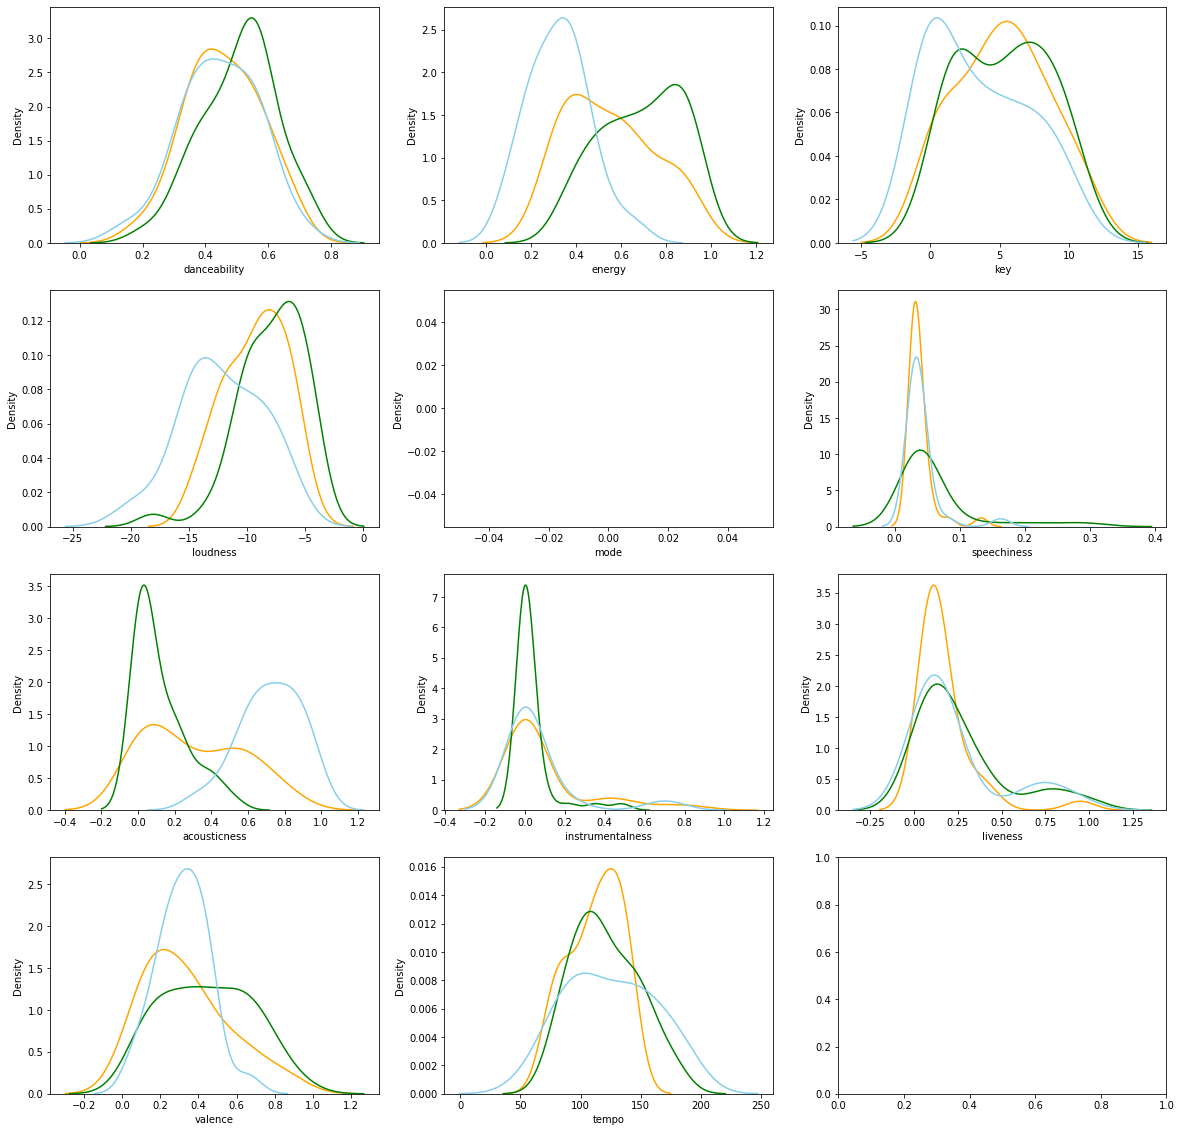

In [ ]:
df_1 = df_n.loc[df_n.clusters == 0, audio_features]
df_2 = df_n.loc[df_n.clusters == 1, audio_features]
df_3 = df_n.loc[df_n.clusters == 2, audio_features]

f, axes = plt.subplots(4, 3, figsize=(20, 20), sharex=False)
for ax, feature in zip(axes.flat, audio_features):
    sns.kdeplot(df_1[feature] , color="orange", ax=ax)
    sns.kdeplot(df_2[feature] , color="green", ax=ax)
    sns.kdeplot(df_3[feature] , color="skyblue", ax=ax)
    #sns.histplot(data=df_n, x=feature, hue="clusters")

#ax2 = ax.twinx()
#sns.kdeplot(df['total_bill'], ax=ax2)

### Correlations

In [ ]:
df_n['2021'] = df_n['2021'].astype('int')
corr = df_n[audio_features.to_list() + ['2021']].corr(method = 'spearman')

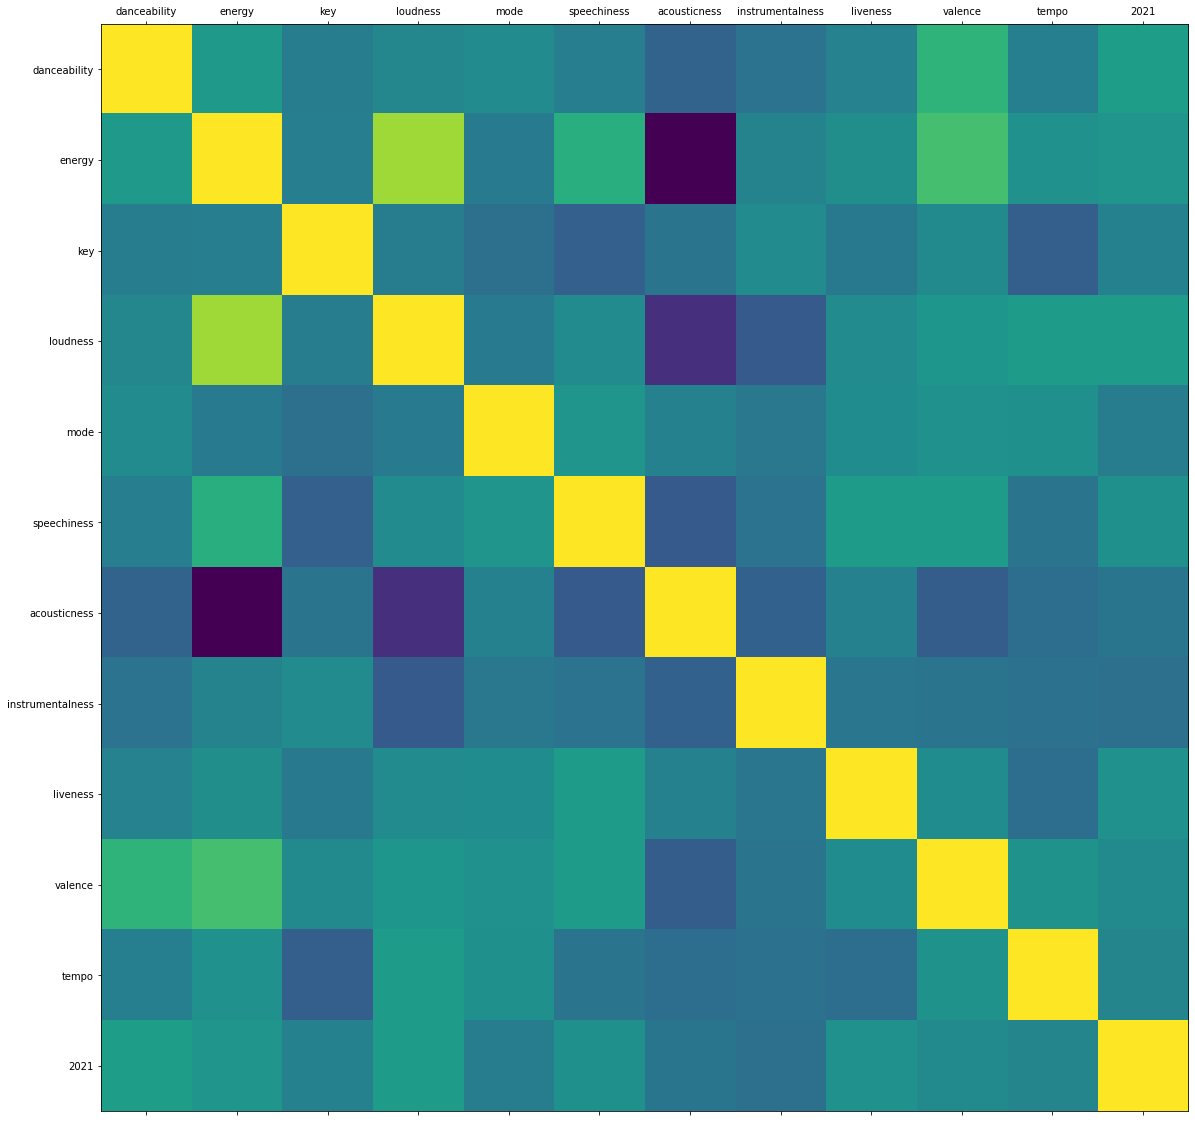

In [ ]:
fig, ax = plt.subplots(figsize=(20,20))
ax.matshow(corr)

xaxis = np.arange(len(audio_features.to_list())+1)
ax.set_xticks(xaxis)
ax.set_yticks(xaxis)
ax.set_xticklabels(audio_features.to_list() + ['2021'])
ax.set_yticklabels(audio_features.to_list() + ['2021'])
plt.show()